In [3]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN, MeanShift, estimate_bandwidth
from sklearn import metrics
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.manifold import MDS
from math import floor
import seaborn as sns
import matplotlib as mpl
import plotly.express as px

from scipy import stats

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Lectura de datos y funcion de normalizacion
def norm_to_zero_one(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())


# Se pueden reemplazar los valores desconocidos por un número
# datos = datos.replace(np.NaN,0)
# O imputar, por ejemplo con la media
def imputar_valores_perdidos(datos):
    for col in datos:
        if col != 'DB040':
            datos[col].fillna(datos[col].mean(), inplace=True)
            
            
# eliminar outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
def eliminar_outliers(X):
    return X[(np.abs(stats.zscore(X)) < 3).any(axis=1)]

def kmeans(X_normal, n_clusters_arg=5, n_init_arg=5, random_state_arg=123456):
    print('----- Ejecutando k-Means',end='')
    k_means = KMeans(init='k-means++', n_clusters=n_clusters_arg, n_init=n_init_arg, random_state=random_state_arg)
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal,subset['DB090']) #se usa DB090 como peso para cada objeto (factor de elevación)
    tiempo = time.time() - t
    print(": {:.2f} segundos, ".format(tiempo), end='')
    
    return k_means, cluster_predict, tiempo

def birch(arg_branching_factor, arg_threshold, X_normal):
    print('----- Ejecutando Birch, branching factor: ' + str(arg_branching_factor) + ', threshold: ' + str(arg_threshold), end='') # -----

    #Tomamos tiempos
    t = time.time()
    # Ejecuto el algoritmo y asigno los clusters
    birch = Birch(branching_factor=arg_branching_factor, threshold=arg_threshold, n_clusters=5)

    cluster_predict = birch.fit_predict(X_normal)
    tiempo = time.time() - t
    #Pinto resultados
    print(": {:.2f} segundos, ".format(tiempo), end='')
    
    return birch, cluster_predict, tiempo

def spectralcluster(arg_n_cluster, X_normal):
    print('----- Ejecutando spectralc luster', end='') # -----

    #Tomamos tiempos
    t = time.time()
    # Ejecuto el algoritmo y asigno los clusters
    spec = SpectralClustering(assign_labels='discretize', n_clusters=arg_n_cluster, random_state=123456)


    cluster_predict = spec.fit_predict(X_normal)
    tiempo = time.time() - t
    #Pinto resultados
    print(": {:.2f} segundos, ".format(tiempo), end='')
    
    return spec, cluster_predict, tiempo

def alg_dbscan(arg_eps, arg_min_samples, X_normal):
    print('----- Ejecutando DBSCAN', end='')

    #Tomamos tiempos
    t = time.time()
    # Ejecuto el algoritmo y asigno los clusters
    dbscan = DBSCAN(eps=arg_eps, min_samples=arg_min_samples)


    cluster_predict = dbscan.fit_predict(X_normal)
    tiempo = time.time() - t
    #Pinto resultados
    print(": {:.2f} segundos, ".format(tiempo), end='')
    
    return dbscan, cluster_predict, tiempo

def meanshift(arg_bandwidth, X_normal):
    print('----- Ejecutando meanshift ', end='')

    #Tomamos tiempos
    t = time.time()
    # Ejecuto el algoritmo y asigno los clusters
    mshift = MeanShift(bandwidth=arg_bandwidth)


    cluster_predict = mshift.fit_predict(X_normal)
    tiempo = time.time() - t
    #Pinto resultados
    print(": {:.2f} segundos, ".format(tiempo), end='')
    
    return mshift, cluster_predict, tiempo


def metrica_CH(X_normal, cluster_predict):
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    return metric_CH


# Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
# Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
def metrica_SC(X_normal, cluster_predict):
    muestra_silhoutte = 0.2 if (len(X) > 10000) else 1.0

    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhoutte*len(X)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    return metric_SC


def tamanio_clusters(clusters):
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()
    tams_clusters = []
    for num,i in size.iteritems():
       print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))
       tams_clusters.append(i)
    return tams_clusters, size


def calcular_centros(algoritmo, X, k_means, cluster_predict):
    if algoritmo == 'kmeans':
        print("rnyto")
        centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
        centers_desnormal = centers.copy()

        # se convierten los centros a los rangos originales antes de normalizar
        for var in list(centers):
            centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())
    else:
        print("a")
        aux = pd.DataFrame(cluster_predict,index=X.index,columns=['clustera'])
        X_clusters = X.join(aux)

        print("b")
        centers = pd.DataFrame([], columns=X.columns)
        centers_desnormal = centers.copy()
        numero_clusters = aux['clustera'].nunique()
        for i in range(numero_clusters):
            grupo_i = X_clusters[X_clusters.clustera == i]
            centroide = grupo_i.mean()
            centroide = pd.DataFrame([[centroide[j] for j in range(len(X.columns))]], columns = X.columns, index = [i])
            centers = centers.append(centroide)

        for var in list(centers):
            centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min()) 
        
        
    return centers, centers_desnormal


# heatmap
def heatmap(centers, centers_desnormal, size, ruta):
    print("---------- Heatmap...")
    centers.index += 1
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    #hm.figure.savefig("centroides.png")
    centers.index -= 1

    k = len(size)
    colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)

    nombre = ruta + "heatmap.png"
    hm.figure.savefig(nombre)
    

# Scatter matrix
def scatter_matrix(X, clusters, size, ruta):
    print("---------- Scatter matrix...")
    # se añade la asignación de clusters como columna a X
    X_kmeans = pd.concat([X, clusters], axis=1)
    k = len(size)
    colors = sns.color_palette('tab10', n_colors=k)

    sns.set()
    variables = list(X_kmeans)
    variables.remove('cluster')
    sns_plot = sns.pairplot(X_kmeans, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    nombre = ruta + "scatter.png"
    sns_plot.savefig(nombre)
    #'''
    
    
# Boxplot
def boxplot(size, centers, ruta):
    print("---------- Boxplots...")
    
    X_kmeans = pd.concat([X, clusters], axis=1)
    k = len(size)
    colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
    
    fig, axes = plt.subplots(k, n_var, sharey=True,figsize=(15,15))
    fig.subplots_adjust(wspace=0,hspace=0)

    centers_sort = centers.sort_values(by=['renta']) #ordenamos por renta para el plot

    rango = []
    for j in range(n_var):
       rango.append([X_kmeans[usadas[j]].min(),X_kmeans[usadas[j]].max()])

    for i in range(k):
        c = centers_sort.index[i]
        dat_filt = X_kmeans.loc[X_kmeans['cluster']==c]
        for j in range(n_var):
            # Esto sale mal si quito el comentario y comento lo sigueinte al profe le sale mal y nos abe por que xd
            #ax = sns.kdeplot(x=dat_filt[usadas[j]], label="", shade=True, color=colors[c], ax=axes[i,j])
            ax = sns.boxplot(x=dat_filt[usadas[j]], notch=True, color=colors[c], flierprops={'marker':'o','markersize':4}, ax=axes[i,j])

            if (i==k-1):
                axes[i,j].set_xlabel(usadas[j])
            else:
                axes[i,j].set_xlabel("")

            if (j==0):
               axes[i,j].set_ylabel("Cluster "+str(c+1))
            else:
                axes[i,j].set_ylabel("")

            axes[i,j].set_yticks([])
            axes[i,j].grid(axis='x', linestyle='-', linewidth='0.2', color='gray')
            axes[i,j].grid(axis='y', b=False)

            ax.set_xlim(rango[j][0]-0.05*(rango[j][1]-rango[j][0]),rango[j][1]+0.05*(rango[j][1]-rango[j][0]))

    fig.set_size_inches(15,15)

    nombre = ruta + "boxplot.png"
    fig.savefig(nombre)
    

# MDS
def graf_MDS(centers, size, ruta):
    print("---------- MDS...")
    X_kmeans = pd.concat([X, clusters], axis=1)
    k = len(size)
    colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
    
    mds = MDS(random_state=123456)
    centers_mds = mds.fit_transform(centers)
    fig=plt.figure(4)
    
    plt.scatter(centers_mds[:,0], centers_mds[:,1], s=size*10, alpha=0.75, c=colors)
    for i in range(k):
        plt.annotate(str(i+1),xy=centers_mds[i],fontsize=18,va='center',ha='center')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    fig.set_size_inches(15,15)

    nombre = ruta + "mds.png"
    plt.savefig(nombre)

def SC_samples(X_normal, cluster_predict):
    metric_SC_samples = metrics.silhouette_samples(X_normal, cluster_predict, metric='euclidean')
    return metric_SC_samples

def parallel_coord(clusters, cluster_predict, X, X_normal, size, ruta):
    print("---------- Parallel coordinates...")
    plt.figure()
    mpl.style.use('default')

    metric_SC_samples = SC_samples(X_normal, cluster_predict)

    X['cluster'] = clusters
    X['SC'] = metric_SC_samples
    df = X
    k = len(size)
    colors = sns.color_palette('tab10', n_colors=k)

    # si se desea aclarar la figura, se pueden eliminar los objetos más lejanos, es decir, SC < umbral, p.ej., 0.3
    df = df.loc[df['SC']>=0.3]

    colors_parcoor = [(round((i//2)/k+0.2*(i%2),3),'rgb'+str(colors[j//2])) for i,j in zip(range(2*k),range(2*k))]

    fig = px.parallel_coordinates(df, dimensions=X.columns,
                                color="cluster", range_color=[-0.5, 4.5],
                                color_continuous_scale=colors_parcoor)

    fig.update_layout(coloraxis_colorbar=dict(
        title="Clusters",
        tickvals=[0,1,2,3,4],
        ticktext=["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5"],
        lenmode="pixels", len=500,
    ))


    nombre = ruta + "parallel.html"
    fig.write_html(nombre)

    
def sacar_graficas(algoritmo, centers, centers_desnormal, size, X, clusters):
    if algoritmo != 'dbscan':
        heatmap(centers, centers_desnormal, size)
        scatter_matrix(X, clusters, size)
        boxplot(size, centers)
        graf_MDS(centers, size)
    else:
        scatter_matrix(X, clusters, size)

def tabla_alg(l):
    # Cabecera de la tabla
    print("\\begin{table}[H]")
    print("\centering")
    print("\caption{Caso 1 - Resultados cambio de parámetros Birch}")
    print("\label{tab:param_birch1}")
    print("\\begin{tabular}{llrrrrr}")
    print("\\toprule")
    print(" Algoritmo & Tiempo (s) & Silhouette & Calinski-Harabasz & Número de clusters \\\\")
    print("\midrule")

    # Contenido de la tabla
    for s in l:
        print(s)
    
    # Cierre de la tabla
    print("\\bottomrule")
    print("\end{tabular}")
    print("\end{table}")

In [ ]:
datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

# Seleccionar casos
subset = datos.loc[(datos['HY030N']>0) & (datos['HC030_F']==1)] #solo los que se conoce el alquiler imputado y gasto en transporte público

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HY030N": "alquiler_imputado", "HC010": "alimentacion_in", "HC030": "transporte"})
usadas = ['renta','alquiler_imputado','alimentacion_in','transporte']

n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]

algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X)

for col in X:
   missing_count = sum(pd.isnull(X[col]))
   if missing_count > 0:
      print(col,missing_count)

# normalizamos
X_normal = X.apply(norm_to_zero_one)

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        res, cluster_predict, tiempo = kmeans(X_normal)
    elif algoritmos[i] == 'birch':
        res, cluster_predict, tiempo = birch(15, 0.1, X_normal)
    elif algoritmos[i] == 'spectral':
        res, cluster_predict, tiempo = spectralcluster(5, X_normal)
    elif algoritmos[i] == 'dbscan':
        res, cluster_predict, tiempo = alg_dbscan(0.126, 20, X_normal)
    elif algoritmos[i] == 'meanshift':
        #bw = estimate_bandwidth(X_normal)
        #res, cluster_predict = meanshift(bw, X_normal)
        break
        break
    
    try:
        print("\n\nMedidas\n\n")
        metrica_CH(X_normal, cluster_predict)

        metrica_SC(X_normal, cluster_predict)
    except:
        print("\n\nDe medidas nada\n\n")
    
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tam_clusters, size = tamanio_clusters(clusters)

    centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)
    print(centers)
    print("aksjdasd")
    print(centers_desnormal)
    #scatter_matrix(X, clusters, size)

----- Ejecutando k-Means: 0.51 segundos, 

Medidas


Calinski-Harabasz Index: 1017.578, Silhouette Coefficient: 0.23347
Tamaño de cada cluster:
0:  1338 (40.28%)
4:  1057 (31.82%)
1:   528 (15.89%)
2:   227 ( 6.83%)
3:   172 ( 5.18%)
rnyto
      renta  alquiler_imputado  alimentacion_in  transporte
0  0.085079           0.228496         0.134197    0.056635
1  0.208552           0.348139         0.233127    0.088658
2  0.169358           0.290759         0.511023    0.095548
3  0.152850           0.263306         0.258642    0.401501
4  0.114563           0.233612         0.269335    0.074533
aksjdasd
          renta  alquiler_imputado  alimentacion_in  transporte
0  22904.003199        5795.167182       295.233404   29.260837
1  67028.754527        8814.675739       512.880038   45.240530
2  53022.252687        7366.527709      1124.251101   48.678414
3  47122.735000        6673.677791       569.011852  201.348837
4  33440.568666        5924.270643       592.537952   38.192053
----- E

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.25 segundos, 

Medidas


Calinski-Harabasz Index: 461.191, Silhouette Coefficient: 0.43012
Tamaño de cada cluster:
3:  2975 (89.55%)
2:   181 ( 5.45%)
0:   132 ( 3.97%)
1:    26 ( 0.78%)
4:     8 ( 0.24%)
a
b
           renta  alquiler_imputado  alimentacion_in  transporte
0   56358.171364        8452.518864      1207.613636   48.507576
1  164336.176923       10839.294231       607.807692   48.961538
2   45628.546575        6606.184530       560.107983  181.917127
3   34017.966524        6337.644928       458.828087   35.222185
4   43793.121250        5292.965000       451.188302  462.500000
aksjdasd
          renta  alquiler_imputado  alimentacion_in     transporte
0  2.014027e+10       2.133214e+08     2.656750e+06   24206.280303
1  5.872752e+10       2.735579e+08     1.337177e+06   24432.807692
2  1.630591e+10       1.667243e+08     1.232238e+06   90777.646409
3  1.215673e+10       1.599470e+08     1.009422e+06   17576.870252
4  1.565000e+10       1.335818e+08     9.926143e+05  

          renta  alimentacion_in  gastos    IRPF
24      26753.6            400.0  193.64  1502.5
37      19490.8            350.0  268.45 -1249.9
39      20876.2            500.0  181.64  -343.0
45     104880.6            500.0  231.52 -4013.9
46      26770.0           1100.0  284.56  -425.0
...         ...              ...     ...     ...
15017   71961.5            500.0  648.85  1117.0
15021   49316.8            800.0  198.36  2110.7
15023   20430.4            300.0  252.53  1759.2
15031   29746.4            300.0  242.69  -440.5
15042   12728.0            250.0  300.75  -119.7

[2292 rows x 4 columns]




----- Ejecutando k-Means: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 625.999, Silhouette Coefficient: 0.33432
Tamaño de cada cluster:
0:  1394 (60.82%)
4:   375 (16.36%)
1:   372 (16.23%)
3:    80 ( 3.49%)
2:    71 ( 3.10%)
rnyto
----- Ejecutando Birch, branching factor: 15, threshold: 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.09 segundos, 

Medidas


Calinski-Harabasz Index: 336.711, Silhouette Coefficient: 0.48426
Tamaño de cada cluster:
4:  2077 (90.62%)
0:   123 ( 5.37%)
3:    46 ( 2.01%)
2:    31 ( 1.35%)
1:    15 ( 0.65%)
a
b
----- Ejecutando spectralc luster: 0.65 segundos, 

Medidas


Calinski-Harabasz Index: 534.083, Silhouette Coefficient: 0.29880
Tamaño de cada cluster:
0:  1104 (48.17%)
4:   400 (17.45%)
1:   386 (16.84%)
2:   209 ( 9.12%)
3:   193 ( 8.42%)
a
b
---------- Heatmap...
---------- MDS...
---------- Boxplots...
----- Ejecutando DBSCAN: 0.12 segundos, 

Medidas


Calinski-Harabasz Index: 333.456, Silhouette Coefficient: 0.67367
Tamaño de cada cluster:
0:  2228 (97.21%)
-1:    64 ( 2.79%)
a
b
----- Ejecutando meanshift : 10.48 segundos, 

Medidas


Calinski-Harabasz Index: 73.801, Silhouette Coefficient: 0.35908
Tamaño de cada cluster:
0:  2078 (90.66%)
5:    41 ( 1.79%)
4:    30 ( 1.31%)
6:    21 ( 0.92%)
26:    21 ( 0.92%)
21:    19 ( 0.83%)
1:    14 ( 0.61%)
30:    13 ( 0.57%)
19

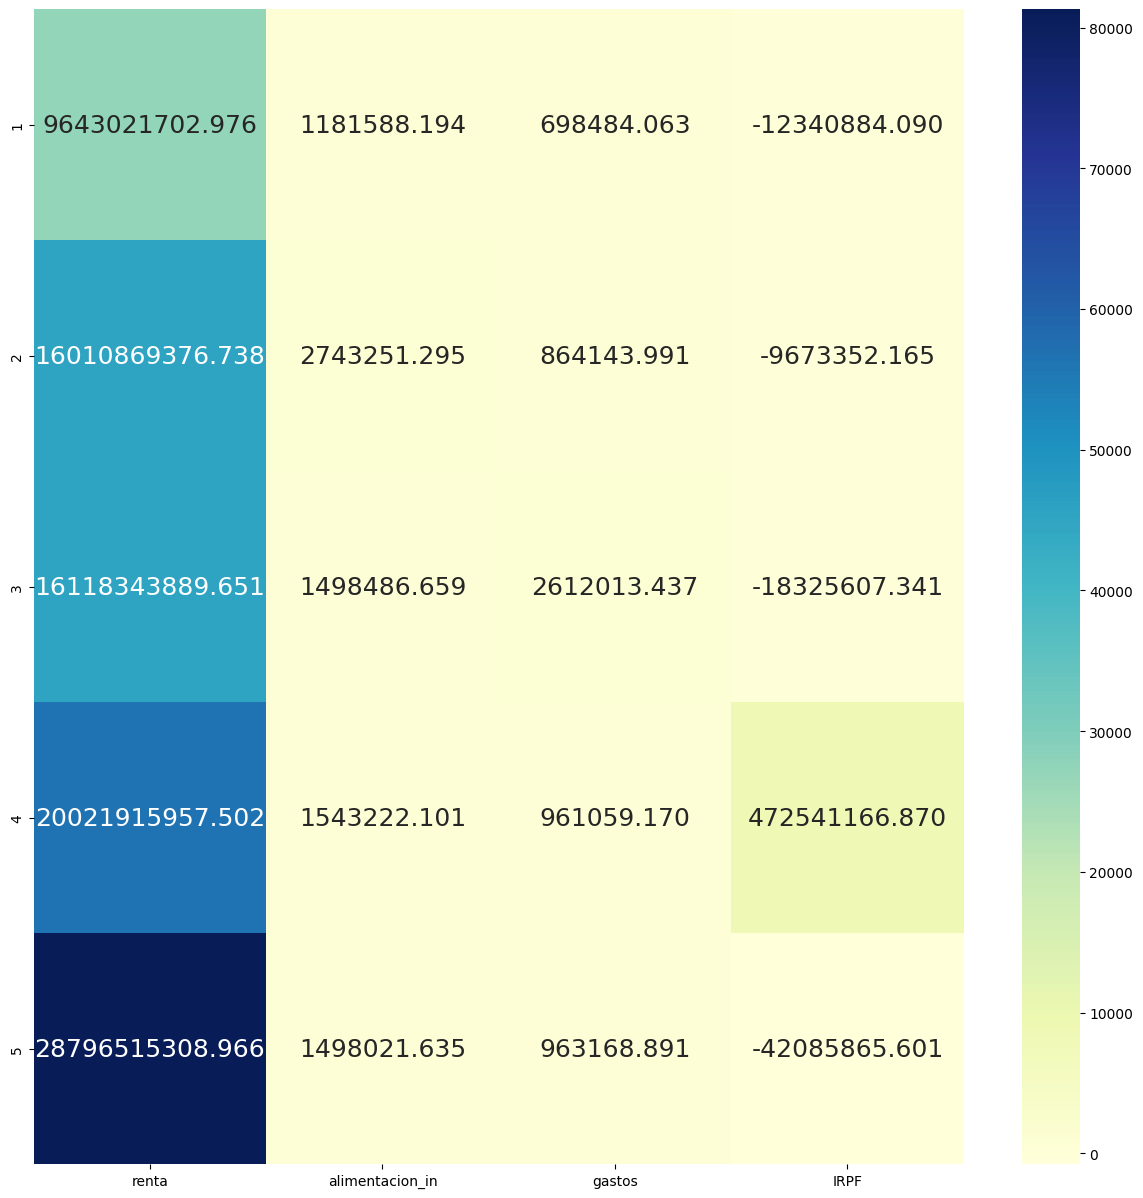

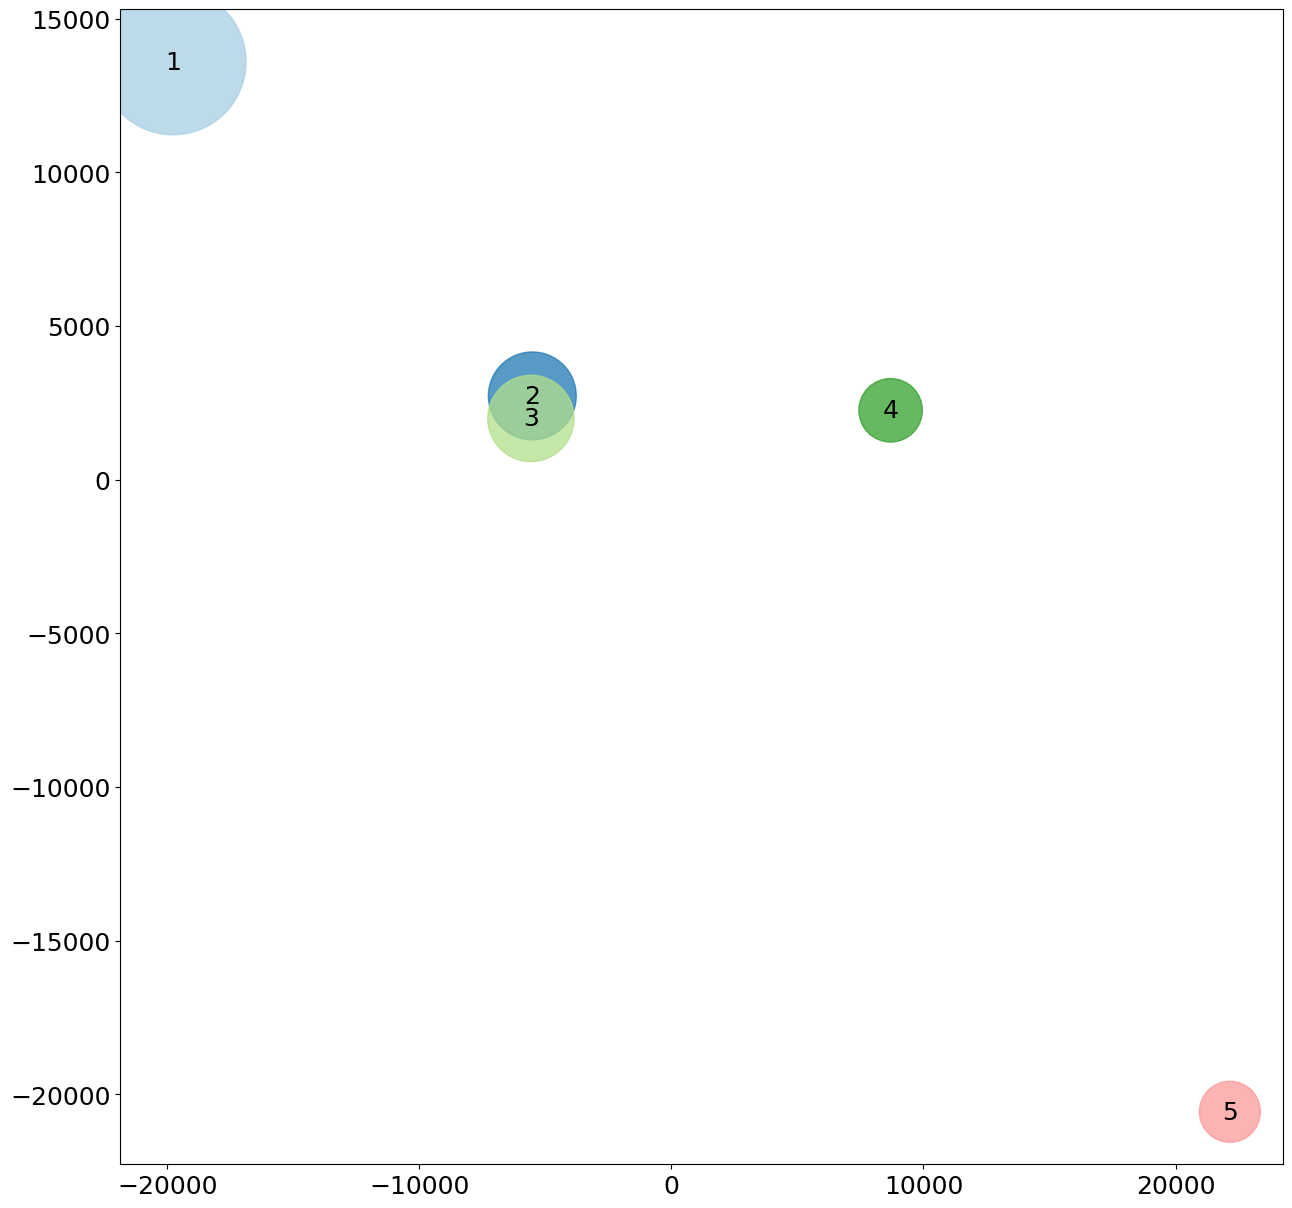

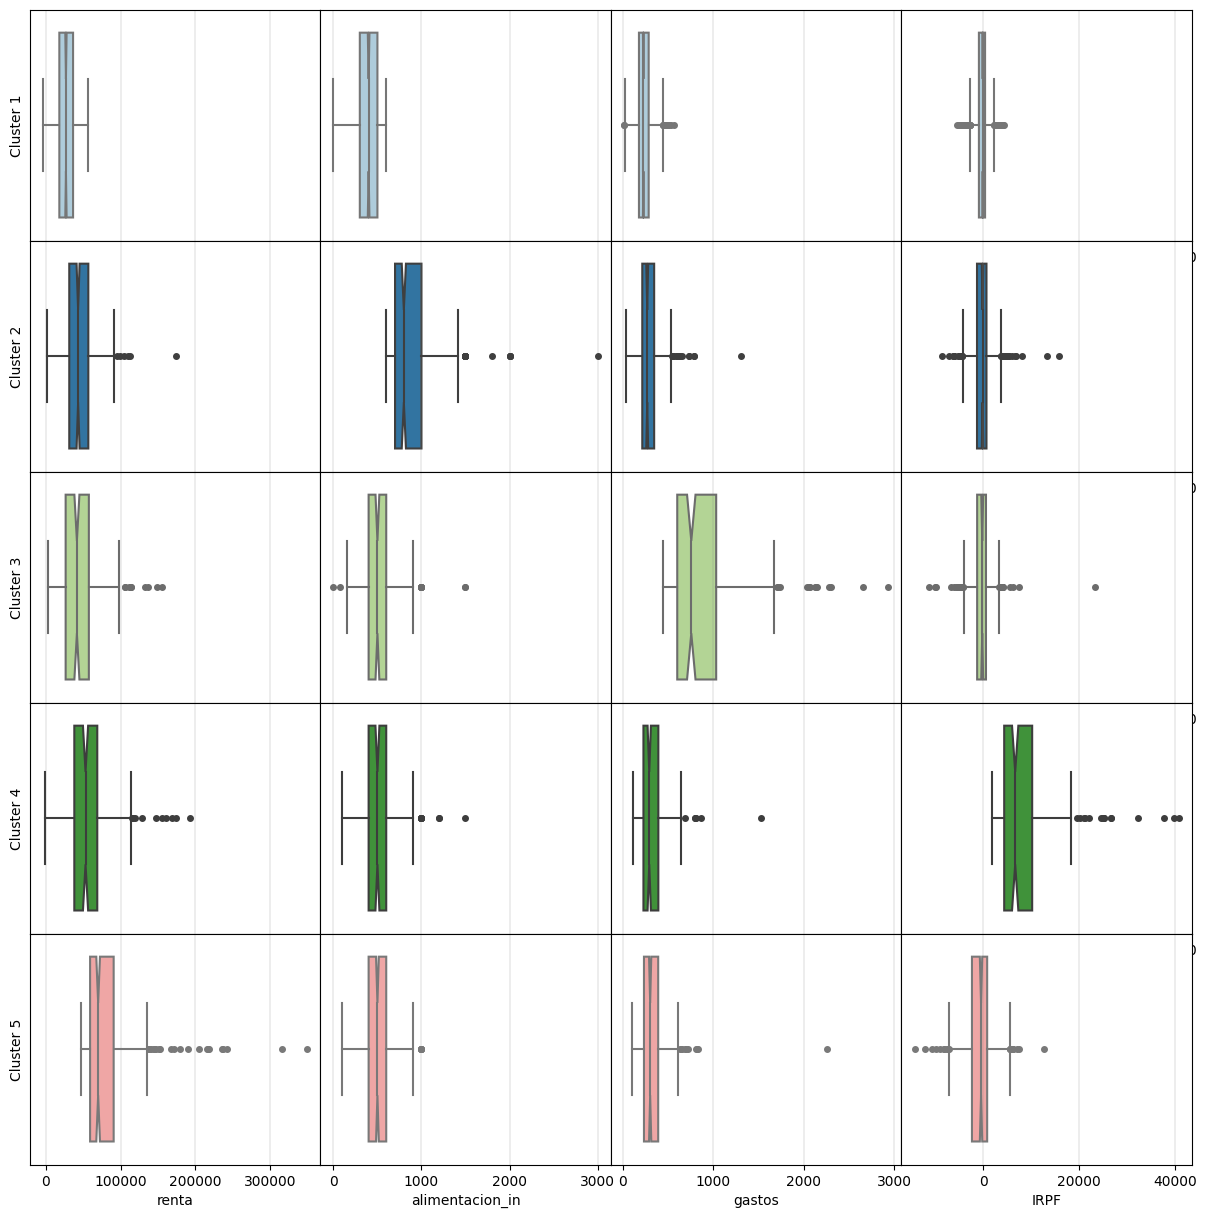

In [12]:
datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)


carpeta = "./caso1/"
lista_tabla = []

# Seleccionar casos
subset = datos.loc[(datos['HY040N']>00) & (datos['HH021']<4) & (datos['HH021_F'] != -1)]

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HH070": "gastos", "HY145N": "IRPF", "HC010": "alimentacion_in"})
usadas = ['renta', 'alimentacion_in', 'gastos', 'IRPF']


n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)

X = eliminar_outliers(X) 

print("\n\n\n")
for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)

# normalizamos
X_normal = X.apply(norm_to_zero_one)

for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        res, cluster_predict, tiempo = kmeans(X_normal)
    elif algoritmos[i] == 'birch':
        res, cluster_predict, tiempo = birch(15, 0.1, X_normal)
    elif algoritmos[i] == 'spectral':
        res, cluster_predict, tiempo = spectralcluster(5, X_normal)
    elif algoritmos[i] == 'dbscan':
        res, cluster_predict, tiempo = alg_dbscan(0.126, 20, X_normal)
    elif algoritmos[i] == 'meanshift':
        bw = estimate_bandwidth(X_normal)
        res, cluster_predict, tiempo = meanshift(bw, X_normal)

    
    try:
        print("\n\nMedidas\n\n")
        ch = metrica_CH(X_normal, cluster_predict)

        sc = metrica_SC(X_normal, cluster_predict)
    except:
        print("\n\nDe medidas nada\n\n")
    
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tam_clusters, size = tamanio_clusters(clusters)

    centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

    s = algoritmos[i]  + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"
    
    lista_tabla.append(s)

    carpeta2 = carpeta + algoritmos[i] + "/"
    
    if algoritmos[i] == 'spectral':
        
      '''try:
          parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
      except:
          print("de parallel nada")'''
      
      
      try:
          heatmap(centers, centers_desnormal, size, carpeta2)
      except:
          print("dep1")
      try:
          graf_MDS(centers, size, carpeta2)
      except:
          print("dep2")
      try:
          boxplot(size, centers, carpeta2)
      except:
          print("dep3")

    #scatter_matrix(X, clusters, size, carpeta2)

  #if algoritmos[i] == 'kmeans':
    #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

In [13]:
# PARAMETROS BIRCH

datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)


carpeta = "./caso1/"
lista_tabla = []

subset = datos.loc[(datos['HY040N']>00) & (datos['HH021']<4) & (datos['HH021_F'] != -1)]

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HH070": "gastos", "HY145N": "IRPF", "HC010": "alimentacion_in"})
usadas = ['renta', 'alimentacion_in', 'gastos', 'IRPF']



n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X) 

# normalizamos
X_normal = X.apply(norm_to_zero_one)

param_birch_branching = [15, 20, 25, 30, 35]
param_birch_threshold = [0.1, 0.15, 0.20, 0.25, 0.30]
for i in range(0, len(param_birch_branching)):
  for j in range(0, len(param_birch_threshold)):
        res, cluster_predict, tiempo = birch(param_birch_branching[i], param_birch_threshold[j], X_normal)
    
        try:
            print("\n\nMedidas\n\n")
            ch = metrica_CH(X_normal, cluster_predict)

            sc = metrica_SC(X_normal, cluster_predict)
        except:
            print("\n\nDe medidas nada\n\n")
        
        # se convierte la asignación de clusters a DataFrame
        clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

        tam_clusters, size = tamanio_clusters(clusters)

        #centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

        s = "birch"  + " & "
        s += "{:.3f}".format(param_birch_branching[i]) + " & "
        s += "{:.3f}".format(param_birch_threshold[j]) + " & "
        s += "{:.3f}".format(tiempo) + " & "
        s += "{:.3f}".format(ch) + " & "
        s += "{:.5f}".format(sc) + " & "
        s += "{:.0f}".format(len(size)) + " \\\\"
        
        lista_tabla.append(s)

#carpeta2 = carpeta + algoritmos[i] + "/"
    
      #if algoritmos[i] == 'spectral':
          
        '''try:
            parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
        except:
            print("de parallel nada")'''
        
        
        '''try:
            heatmap(centers, centers_desnormal, size, carpeta2)
        except:
            print("dep1")
        try:
            graf_MDS(centers, size, carpeta2)
        except:
            print("dep2")
        try:
            boxplot(size, centers, carpeta2)
        except:
            print("dep3")
        #scatter_matrix(X, clusters, size, carpeta2)'''

      #if algoritmos[i] == 'kmeans':
        #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

          renta  alimentacion_in  gastos    IRPF
24      26753.6            400.0  193.64  1502.5
37      19490.8            350.0  268.45 -1249.9
39      20876.2            500.0  181.64  -343.0
45     104880.6            500.0  231.52 -4013.9
46      26770.0           1100.0  284.56  -425.0
...         ...              ...     ...     ...
15017   71961.5            500.0  648.85  1117.0
15021   49316.8            800.0  198.36  2110.7
15023   20430.4            300.0  252.53  1759.2
15031   29746.4            300.0  242.69  -440.5
15042   12728.0            250.0  300.75  -119.7

[2292 rows x 4 columns]
----- Ejecutando Birch, branching factor: 15, threshold: 0.1: 0.09 segundos, 

Medidas


Calinski-Harabasz Index: 336.711, 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



Silhouette Coefficient: 0.48426
Tamaño de cada cluster:
4:  2077 (90.62%)
0:   123 ( 5.37%)
3:    46 ( 2.01%)
2:    31 ( 1.35%)
1:    15 ( 0.65%)
----- Ejecutando Birch, branching factor: 15, threshold: 0.15: 0.07 segundos, 

Medidas


Calinski-Harabasz Index: 192.073, 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



Silhouette Coefficient: 0.58865
Tamaño de cada cluster:
2:  2213 (96.55%)
1:    64 ( 2.79%)
3:     7 ( 0.31%)
0:     6 ( 0.26%)
4:     2 ( 0.09%)
----- Ejecutando Birch, branching factor: 15, threshold: 0.2: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 206.873, 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



Silhouette Coefficient: 0.60273
Tamaño de cada cluster:
3:  2223 (96.99%)
4:    29 ( 1.27%)
2:    25 ( 1.09%)
1:    10 ( 0.44%)
0:     5 ( 0.22%)
----- Ejecutando Birch, branching factor: 15, threshold: 0.25: 0.06 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
----- Ejecutando Birch, branching factor: 15, threshold: 0.3: 0.05 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
----- Ejecutando Birch, branching factor: 20, threshold: 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.15 segundos, 

Medidas


Calinski-Harabasz Index: 173.266, Silhouette Coefficient: 0.58162
Tamaño de cada cluster:
0:  2234 (97.47%)
2:    26 ( 1.13%)
3:    23 ( 1.00%)
1:     7 ( 0.31%)
4:     2 ( 0.09%)
----- Ejecutando Birch, branching factor: 20, threshold: 0.15

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.08 segundos, 

Medidas


Calinski-Harabasz Index: 180.842, Silhouette Coefficient: 0.58567
Tamaño de cada cluster:
2:  2216 (96.68%)
1:    65 ( 2.84%)
3:     5 ( 0.22%)
0:     4 ( 0.17%)
4:     2 ( 0.09%)
----- Ejecutando Birch, branching factor: 20, threshold: 0.2: 0.05 segundos, 

Medidas


Calinski-Harabasz Index: 206.873, Silhouette Coefficient: 0.60273
Tamaño de cada cluster:
3:  2223 (96.99%)
4:    29 ( 1.27%)
2:    25 ( 1.09%)
1:    10 ( 0.44%)
0:     5 ( 0.22%)
----- Ejecutando Birch, branching factor: 20, threshold: 0.25: 0.05 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
----- Ejecutando Birch, branching factor: 20, threshold: 0.3: 0.05 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
----- Ejecutando Birch, branching factor: 25, threshold: 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.15 segundos, 

Medidas


Calinski-Harabasz Index: 312.603, Silhouette Coefficient: 0.49236
Tamaño de cada cluster:
3:  2133 (93.06%)
0:    68 ( 2.97%)
4:    46 ( 2.01%)
1:    29 ( 1.27%)
2:    16 ( 0.70%)
----- Ejecutando Birch, branching factor: 25, threshold: 0.15

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 184.304, Silhouette Coefficient: 0.57974
Tamaño de cada cluster:
2:  2211 (96.47%)
1:    70 ( 3.05%)
4:     5 ( 0.22%)
0:     4 ( 0.17%)
3:     2 ( 0.09%)
----- Ejecutando Birch, branching factor: 25, threshold: 0.2: 0.05 segundos, 

Medidas


Calinski-Harabasz Index: 206.873, Silhouette Coefficient: 0.60273
Tamaño de cada cluster:
3:  2223 (96.99%)
4:    29 ( 1.27%)
2:    25 ( 1.09%)
1:    10 ( 0.44%)
0:     5 ( 0.22%)
----- Ejecutando Birch, branching factor: 25, threshold: 0.25: 0.05 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
----- Ejecutando Birch, branching factor: 25, threshold: 0.3: 0.04 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
----- Ejecutando Birch, branching factor: 30, threshold: 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.14 segundos, 

Medidas


Calinski-Harabasz Index: 292.036, Silhouette Coefficient: 0.52240
Tamaño de cada cluster:
4:  2109 (92.02%)
0:   103 ( 4.49%)
2:    46 ( 2.01%)
1:    30 ( 1.31%)
3:     4 ( 0.17%)
----- Ejecutando Birch, branching factor: 30, threshold: 0.15

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 184.304, Silhouette Coefficient: 0.57974
Tamaño de cada cluster:
2:  2211 (96.47%)
1:    70 ( 3.05%)
4:     5 ( 0.22%)
0:     4 ( 0.17%)
3:     2 ( 0.09%)
----- Ejecutando Birch, branching factor: 30, threshold: 0.2

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.07 segundos, 

Medidas


Calinski-Harabasz Index: 206.873, Silhouette Coefficient: 0.60273
Tamaño de cada cluster:
3:  2223 (96.99%)
4:    29 ( 1.27%)
2:    25 ( 1.09%)
1:    10 ( 0.44%)
0:     5 ( 0.22%)
----- Ejecutando Birch, branching factor: 30, threshold: 0.25: 0.06 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
----- Ejecutando Birch, branching factor: 30, threshold: 0.3

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.07 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
----- Ejecutando Birch, branching factor: 35, threshold: 0.1: 0.13 segundos, 

Medidas


Calinski-Harabasz Index: 355.783, Silhouette Coefficient: 0.42852
Tamaño de cada cluster:
3:  2042 (89.09%)
0:   134 ( 5.85%)
4:    48 ( 2.09%)
2:    41 ( 1.79%)
1:    27 ( 1.18%)
----- Ejecutando Birch, branching factor: 35, threshold: 0.15: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 184.304, Silhouette Coefficient: 0.57974
Tamaño de cada cluster:
2:  2211 (96.47%)
1:    70 ( 3.05%)
4:     5 ( 0.22%)
0:     4 ( 0.17%)
3:     2 ( 0.09%)
----- Ejecutando Birch, branching factor: 35, threshold: 0.2

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 206.873, Silhouette Coefficient: 0.60273
Tamaño de cada cluster:
3:  2223 (96.99%)
4:    29 ( 1.27%)
2:    25 ( 1.09%)
1:    10 ( 0.44%)
0:     5 ( 0.22%)
----- Ejecutando Birch, branching factor: 35, threshold: 0.25: 0.06 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
----- Ejecutando Birch, branching factor: 35, threshold: 0.3: 0.05 segundos, 

Medidas




De medidas nada


Tamaño de cada cluster:
0:  2292 (100.00%)
\begin{table}[H]
\centering
\caption{Caso 1 - Resultados cambio de parámetros Birch}
\label{tab:param_birch1}
\begin{tabular}{llrrrrr}
\toprule
 Algoritmo & Tiempo (s) & Silhouette & Calinski-Harabasz & Número de clusters \\
\midrule
birch & 15.000 & 0.100 & 0.087 & 336.711 & 0.48426 & 5 \\
birch & 15.000 & 0.150 & 0.065 & 192.073 & 0.58865 & 5 \\
birch & 15.000 & 0.200 & 0.060 & 206.873 & 0.60273 & 5 \\
birch & 15.000 & 0.250 & 0.062 & 206.873 & 0.60273 & 1 \\
birch & 15.000 & 0.3

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:717: ConvergenceWarning:

Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



In [15]:
# PARAMETROS DBSCAN

datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

carpeta = "./caso1/"
lista_tabla = []

subset = datos.loc[(datos['HY040N']>00) & (datos['HH021']<4) & (datos['HH021_F'] != -1)]

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HH070": "gastos", "HY145N": "IRPF", "HC010": "alimentacion_in"})
usadas = ['renta', 'alimentacion_in', 'gastos', 'IRPF']


n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X) 

# normalizamos
X_normal = X.apply(norm_to_zero_one)

param_dbscan_eps = [0.126, 0.130, 0.150, 0.170, 0.2]
param_dbscan_min_samples = [15, 20, 25, 30, 35]
for i in range(0, len(param_birch_branching)):
  for j in range(0, len(param_birch_threshold)):
        res, cluster_predict, tiempo = alg_dbscan(param_dbscan_eps[i], param_dbscan_min_samples[j], X_normal)
    
        try:
            print("\n\nMedidas\n\n")
            ch = metrica_CH(X_normal, cluster_predict)

            sc = metrica_SC(X_normal, cluster_predict)
        except:
            print("\n\nDe medidas nada\n\n")
        
        # se convierte la asignación de clusters a DataFrame
        clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

        tam_clusters, size = tamanio_clusters(clusters)

        #centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

        s = "dbscan"  + " & "
        s += "{:.3f}".format(param_dbscan_eps[i]) + " & "
        s += "{:.3f}".format(param_dbscan_min_samples[j]) + " & "
        s += "{:.3f}".format(tiempo) + " & "
        s += "{:.3f}".format(ch) + " & "
        s += "{:.5f}".format(sc) + " & "
        s += "{:.0f}".format(len(size)) + " \\\\"
        
        lista_tabla.append(s)

#carpeta2 = carpeta + algoritmos[i] + "/"
    
      #if algoritmos[i] == 'spectral':
          
        '''try:
            parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
        except:
            print("de parallel nada")'''
        
        
        '''try:
            heatmap(centers, centers_desnormal, size, carpeta2)
        except:
            print("dep1")
        try:
            graf_MDS(centers, size, carpeta2)
        except:
            print("dep2")
        try:
            boxplot(size, centers, carpeta2)
        except:
            print("dep3")
        #scatter_matrix(X, clusters, size, carpeta2)'''

      #if algoritmos[i] == 'kmeans':
        #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

          renta  alimentacion_in  gastos    IRPF
24      26753.6            400.0  193.64  1502.5
37      19490.8            350.0  268.45 -1249.9
39      20876.2            500.0  181.64  -343.0
45     104880.6            500.0  231.52 -4013.9
46      26770.0           1100.0  284.56  -425.0
...         ...              ...     ...     ...
15017   71961.5            500.0  648.85  1117.0
15021   49316.8            800.0  198.36  2110.7
15023   20430.4            300.0  252.53  1759.2
15031   29746.4            300.0  242.69  -440.5
15042   12728.0            250.0  300.75  -119.7

[2292 rows x 4 columns]
----- Ejecutando DBSCAN: 0.13 segundos, 

Medidas


Calinski-Harabasz Index: 314.352, Silhouette Coefficient: 0.67749
Tamaño de cada cluster:
0:  2233 (97.43%)
-1:    59 ( 2.57%)
----- Ejecutando DBSCAN: 0.12 segundos, 

Medidas


Calinski-Harabasz Index: 333.456, Silhouette Coefficient: 0.67367
Tamaño de cada cluster:
0:  2228 (97.21%)
-1:    64 ( 2.79%)
----- Ejecutando DBSCAN: 0.12

In [ ]:
datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

carpeta = "./caso2A/"
lista_tabla = []

subset = datos.loc[((datos['HY020']<15000))]
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HC010":"alimentos", "HY060N":"asistencia social", "HH070": "gastos"})

usadas = ['renta', 'alimentos', 'asistencia social', 'gastos']



n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)

X = eliminar_outliers(X) 

print("\n\n\n")
for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)

# normalizamos
X_normal = X.apply(norm_to_zero_one)

for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        res, cluster_predict, tiempo = kmeans(X_normal)
    elif algoritmos[i] == 'birch':
        res, cluster_predict, tiempo = birch(15, 0.1, X_normal)
    elif algoritmos[i] == 'spectral':
        res, cluster_predict, tiempo = spectralcluster(5, X_normal)
    elif algoritmos[i] == 'dbscan':
        res, cluster_predict, tiempo = alg_dbscan(0.126, 20, X_normal)
    elif algoritmos[i] == 'meanshift':
        bw = estimate_bandwidth(X_normal)
        res, cluster_predict, tiempo = meanshift(bw, X_normal)
        #break
        #break
    
    try:
        print("\n\nMedidas\n\n")
        ch = metrica_CH(X_normal, cluster_predict)

        sc = metrica_SC(X_normal, cluster_predict)
    except:
        print("\n\nDe medidas nada\n\n")
    
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tam_clusters, size = tamanio_clusters(clusters)

    centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

    s = algoritmos[i]  + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"
    
    lista_tabla.append(s)

    carpeta2 = carpeta + algoritmos[i] + "/"
    

    if algoritmos[i] == 'kmeans':
        
      '''try:
          parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
      except:
          print("de parallel nada")'''
      
      
      '''try:
          heatmap(centers, centers_desnormal, size, carpeta2)
      except:
          print("dep1")
      try:
          graf_MDS(centers, size, carpeta2)
      except:
          print("dep2")
      try:
          boxplot(size, centers, carpeta2)
      except:
          print("dep3")'''
      #scatter_matrix(X, clusters, size, carpeta2)

    #if algoritmos[i] == 'kmeans':
      #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

         renta  alimentos  asistencia social  gastos
0          0.0     1000.0                0.0  188.02
1      13221.5      500.0                0.0  119.78
17     11420.0      120.0                0.0  502.19
25     12311.8      400.0                0.0  371.14
32     13537.1      400.0                0.0  169.68
...        ...        ...                ...     ...
15024   9056.1      500.0                0.0  526.78
15027  12870.7      250.0                0.0   65.08
15037   9060.9      400.0                0.0  141.32
15041   5564.1      250.0                0.0   67.70
15042  12728.0      250.0                0.0  300.75

[3197 rows x 4 columns]




----- Ejecutando k-Means: 0.07 segundos, 

Medidas


Calinski-Harabasz Index: 1157.588, Silhouette Coefficient: 0.31325
Tamaño de cada cluster:
3:  1105 (34.56%)
2:  1063 (33.25%)
1:   477 (14.92%)
0:   421 (13.17%)
4:   131 ( 4.10%)
rnyto
---------- Parallel coordinates...
----- Ejecutando Birch, branching factor: 15, threshold: 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



Silhouette Coefficient: 0.26449
Tamaño de cada cluster:
1:  2571 (80.42%)
4:   455 (14.23%)
2:    94 ( 2.94%)
0:    70 ( 2.19%)
3:     7 ( 0.22%)
a
b
----- Ejecutando spectralc luster: 1.75 segundos, 

Medidas


Calinski-Harabasz Index: 1068.474, Silhouette Coefficient: 0.30286
Tamaño de cada cluster:
1:  1026 (32.09%)
0:   965 (30.18%)
4:   558 (17.45%)
2:   471 (14.73%)
3:   177 ( 5.54%)
a
b
----- Ejecutando DBSCAN: 0.16 segundos, 

Medidas


Calinski-Harabasz Index: 304.282, Silhouette Coefficient: 0.60850
Tamaño de cada cluster:
0:  3105 (97.12%)
-1:    92 ( 2.88%)
a
b
----- Ejecutando meanshift : 18.06 segundos, 

Medidas


Calinski-Harabasz Index: 184.067, Silhouette Coefficient: 0.40807
Tamaño de cada cluster:
0:  2924 (91.46%)
1:   155 ( 4.85%)
2:    38 ( 1.19%)
6:    37 ( 1.16%)
3:    21 ( 0.66%)
4:    10 ( 0.31%)
5:     4 ( 0.13%)
9:     3 ( 0.09%)
10:     3 ( 0.09%)
7:     1 ( 0.03%)
8:     1 ( 0.03%)
a
b
\begin{table}[H]
\centering
\caption{Caso 1 - Resultados cambio de par

<Figure size 432x288 with 0 Axes>

In [ ]:
# PARAMETROS DBSCAN

datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

carpeta = "./caso2A/"
lista_tabla = []


subset = datos.loc[((datos['HY020']<15000))]
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HC010":"alimentos", "HY060N":"asistencia social", "HH070": "gastos"})

usadas = ['renta', 'alimentos', 'asistencia social', 'gastos']



n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X) 

# normalizamos
X_normal = X.apply(norm_to_zero_one)


param_dbscan_eps = [0.126, 0.130, 0.150, 0.170, 0.2]
param_dbscan_min_samples = [15, 20, 25, 30, 35]
for i in range(0, len(param_birch_branching)):
  for j in range(0, len(param_birch_threshold)):
        res, cluster_predict, tiempo = alg_dbscan(param_dbscan_eps[i], param_dbscan_min_samples[j], X_normal)
    
        try:
            print("\n\nMedidas\n\n")
            ch = metrica_CH(X_normal, cluster_predict)

            sc = metrica_SC(X_normal, cluster_predict)
        except:
            print("\n\nDe medidas nada\n\n")
        
        # se convierte la asignación de clusters a DataFrame
        clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

        tam_clusters, size = tamanio_clusters(clusters)

        #centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

        s = "dbscan"  + " & "
        s += "{:.3f}".format(param_dbscan_eps[i]) + " & "
        s += "{:.3f}".format(param_dbscan_min_samples[j]) + " & "
        s += "{:.3f}".format(tiempo) + " & "
        s += "{:.3f}".format(ch) + " & "
        s += "{:.5f}".format(sc) + " & "
        s += "{:.0f}".format(len(size)) + " \\\\"
        
        lista_tabla.append(s)

#carpeta2 = carpeta + algoritmos[i] + "/"
    
      #if algoritmos[i] == 'spectral':
          
        '''try:
            parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
        except:
            print("de parallel nada")'''
        
        
        '''try:
            heatmap(centers, centers_desnormal, size, carpeta2)
        except:
            print("dep1")
        try:
            graf_MDS(centers, size, carpeta2)
        except:
            print("dep2")
        try:
            boxplot(size, centers, carpeta2)
        except:
            print("dep3")
        #scatter_matrix(X, clusters, size, carpeta2)'''

      #if algoritmos[i] == 'kmeans':
        #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

         renta  alimentos  asistencia social  gastos
0          0.0     1000.0                0.0  188.02
1      13221.5      500.0                0.0  119.78
17     11420.0      120.0                0.0  502.19
25     12311.8      400.0                0.0  371.14
32     13537.1      400.0                0.0  169.68
...        ...        ...                ...     ...
15024   9056.1      500.0                0.0  526.78
15027  12870.7      250.0                0.0   65.08
15037   9060.9      400.0                0.0  141.32
15041   5564.1      250.0                0.0   67.70
15042  12728.0      250.0                0.0  300.75

[3197 rows x 4 columns]
----- Ejecutando DBSCAN: 0.21 segundos, 

Medidas


Calinski-Harabasz Index: 283.280, Silhouette Coefficient: 0.62692
Tamaño de cada cluster:
0:  3121 (97.62%)
-1:    76 ( 2.38%)
----- Ejecutando DBSCAN: 0.18 segundos, 

Medidas


Calinski-Harabasz Index: 304.282, Silhouette Coefficient: 0.60850
Tamaño de cada cluster:
0:  3105 (97.12%)


In [ ]:
# PARAMETROS KMEANS

datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

carpeta = "./caso2A/"
lista_tabla = []


# Seleccionar casos
#subset = datos.loc[(datos['HY020']<15000) & (datos['HY060N']>500) & (datos['HY023_F'] != -1)] #solo los que se conoce el alquiler imputado y gasto en transporte público

subset = datos.loc[((datos['HY020']<15000))]
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HC010":"alimentos", "HY060N":"asistencia social", "HH070": "gastos"})

usadas = ['renta', 'alimentos', 'asistencia social', 'gastos']



n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X) 

# normalizamos
X_normal = X.apply(norm_to_zero_one)



param_kmeans_nclusters = [3,4,5,6,7,8,9,10]
for i in range(0, len(param_kmeans_nclusters)):
      res, cluster_predict, tiempo = kmeans(X_normal, param_kmeans_nclusters[i])
  
      try:
          print("\n\nMedidas\n\n")
          ch = metrica_CH(X_normal, cluster_predict)

          sc = metrica_SC(X_normal, cluster_predict)
      except:
          print("\n\nDe medidas nada\n\n")
      
      # se convierte la asignación de clusters a DataFrame
      clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

      tam_clusters, size = tamanio_clusters(clusters)

      #centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

      s = "kmeans"  + " & "
      s += "{:.3f}".format(param_kmeans_nclusters[i]) + " & "
      s += "{:.3f}".format(tiempo) + " & "
      s += "{:.3f}".format(ch) + " & "
      s += "{:.5f}".format(sc) + " & "
      s += "{:.0f}".format(len(size)) + " \\\\"
      
      lista_tabla.append(s)

#carpeta2 = carpeta + algoritmos[i] + "/"
  
    #if algoritmos[i] == 'spectral':
        
      '''try:
          parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
      except:
          print("de parallel nada")'''
      
      
      '''try:
          heatmap(centers, centers_desnormal, size, carpeta2)
      except:
          print("dep1")
      try:
          graf_MDS(centers, size, carpeta2)
      except:
          print("dep2")
      try:
          boxplot(size, centers, carpeta2)
      except:
          print("dep3")
      #scatter_matrix(X, clusters, size, carpeta2)'''

    #if algoritmos[i] == 'kmeans':
      #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

         renta  alimentos  asistencia social  gastos
0          0.0     1000.0                0.0  188.02
1      13221.5      500.0                0.0  119.78
17     11420.0      120.0                0.0  502.19
25     12311.8      400.0                0.0  371.14
32     13537.1      400.0                0.0  169.68
...        ...        ...                ...     ...
15024   9056.1      500.0                0.0  526.78
15027  12870.7      250.0                0.0   65.08
15037   9060.9      400.0                0.0  141.32
15041   5564.1      250.0                0.0   67.70
15042  12728.0      250.0                0.0  300.75

[3197 rows x 4 columns]
----- Ejecutando k-Means: 0.22 segundos, 

Medidas


Calinski-Harabasz Index: 960.927, Silhouette Coefficient: 0.28417
Tamaño de cada cluster:
0:  1701 (53.21%)
1:  1362 (42.60%)
2:   134 ( 4.19%)
----- Ejecutando k-Means: 0.12 segundos, 

Medidas


Calinski-Harabasz Index: 1162.049, Silhouette Coefficient: 0.31899
Tamaño de cada cluster

          renta  alimentos  asistencia social  gastos
4      39660.00      400.0               0.00  381.53
5      65000.00      400.0               0.00  249.06
6      30030.00      300.0               0.00  420.68
7      49077.30      400.0               0.00  326.22
8      30795.30      300.0               0.00  211.52
...         ...        ...                ...     ...
15031  29746.40      300.0               0.00  242.69
15034  26860.60      400.0               0.00  192.98
15035  27481.50      300.0               0.00  155.91
15038  39969.70      600.0            1200.00  179.37
15039  66003.88      300.0            2503.98  304.87

[8372 rows x 4 columns]




----- Ejecutando k-Means: 0.37 segundos, 

Medidas


Calinski-Harabasz Index: 2962.319, Silhouette Coefficient: 0.30911
Tamaño de cada cluster:
0:  4391 (52.45%)
4:  1984 (23.70%)
3:   708 ( 8.46%)
1:   697 ( 8.33%)
2:   592 ( 7.07%)
rnyto
---------- Heatmap...
---------- MDS...
---------- Boxplots...
----- Ejecutando Bir

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.28 segundos, 

Medidas


Calinski-Harabasz Index: 645.084, Silhouette Coefficient: 0.47807
Tamaño de cada cluster:
0:  8001 (95.57%)
4:   277 ( 3.31%)
3:    76 ( 0.91%)
2:    14 ( 0.17%)
1:     4 ( 0.05%)
a
b
----- Ejecutando spectralc luster: 20.87 segundos, 

Medidas


Calinski-Harabasz Index: 2145.100, Silhouette Coefficient: 0.32184
Tamaño de cada cluster:
0:  3711 (44.33%)
1:  2101 (25.10%)
2:  1366 (16.32%)
4:  1040 (12.42%)
3:   154 ( 1.84%)
a
b
----- Ejecutando DBSCAN: 1.48 segundos, 

Medidas


Calinski-Harabasz Index: 473.629, Silhouette Coefficient: 0.75774
Tamaño de cada cluster:
0:  8325 (99.44%)
-1:    47 ( 0.56%)
a
b
----- Ejecutando meanshift : 57.23 segundos, 

Medidas


Calinski-Harabasz Index: 211.786, Silhouette Coefficient: 0.40726
Tamaño de cada cluster:
0:  7817 (93.37%)
23:   221 ( 2.64%)
3:    93 ( 1.11%)
6:    58 ( 0.69%)
2:    52 ( 0.62%)
1:    30 ( 0.36%)
10:    29 ( 0.35%)
4:    25 ( 0.30%)
5:    11 ( 0.13%)
28:     5 ( 0.06%)
24:     5 ( 0.06%)
30:    

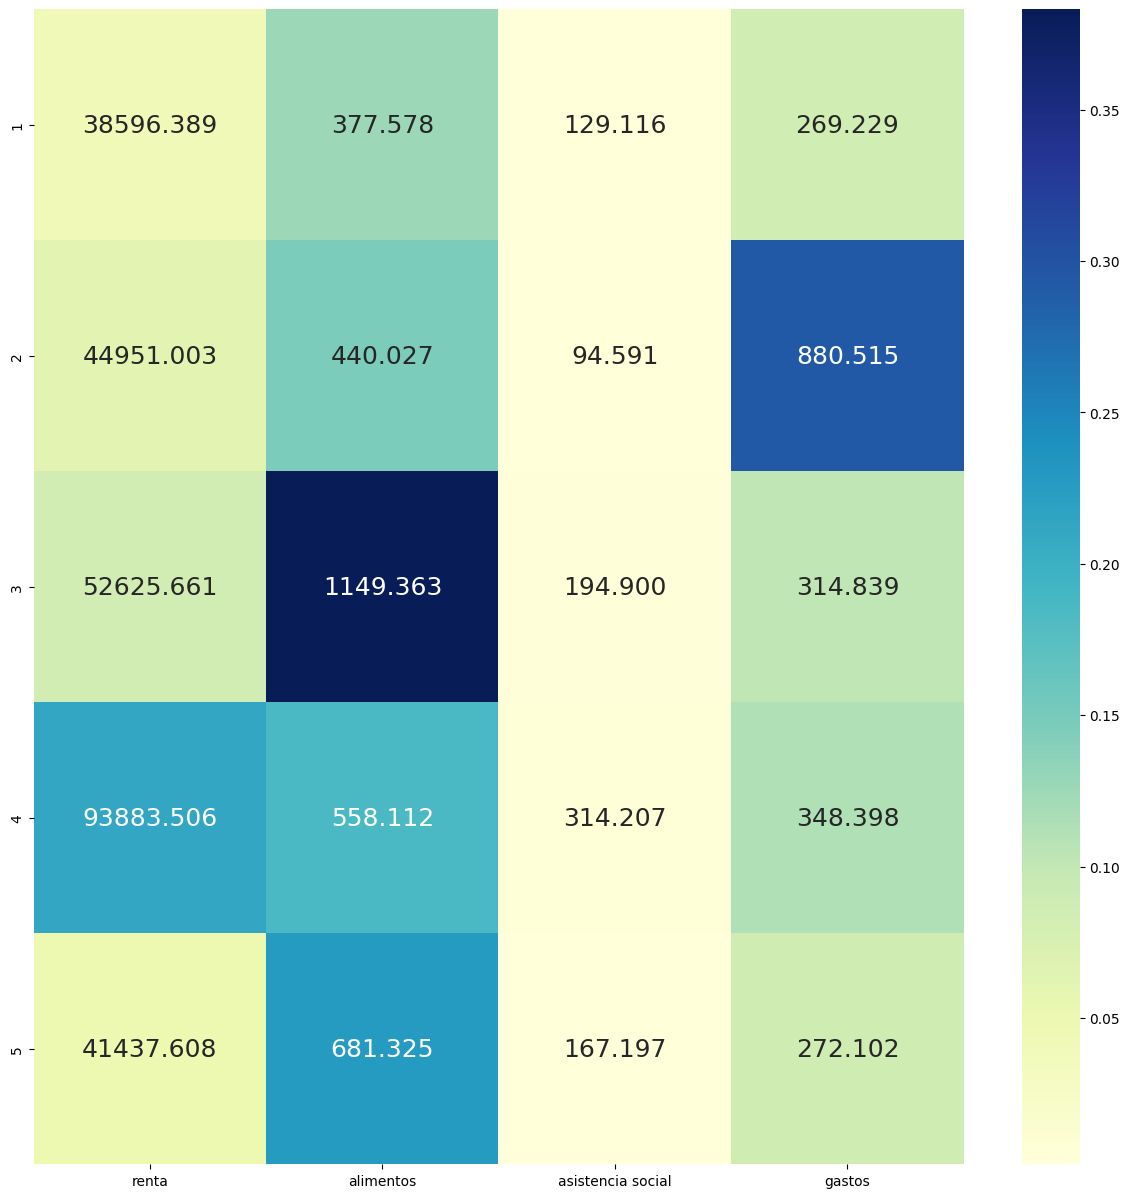

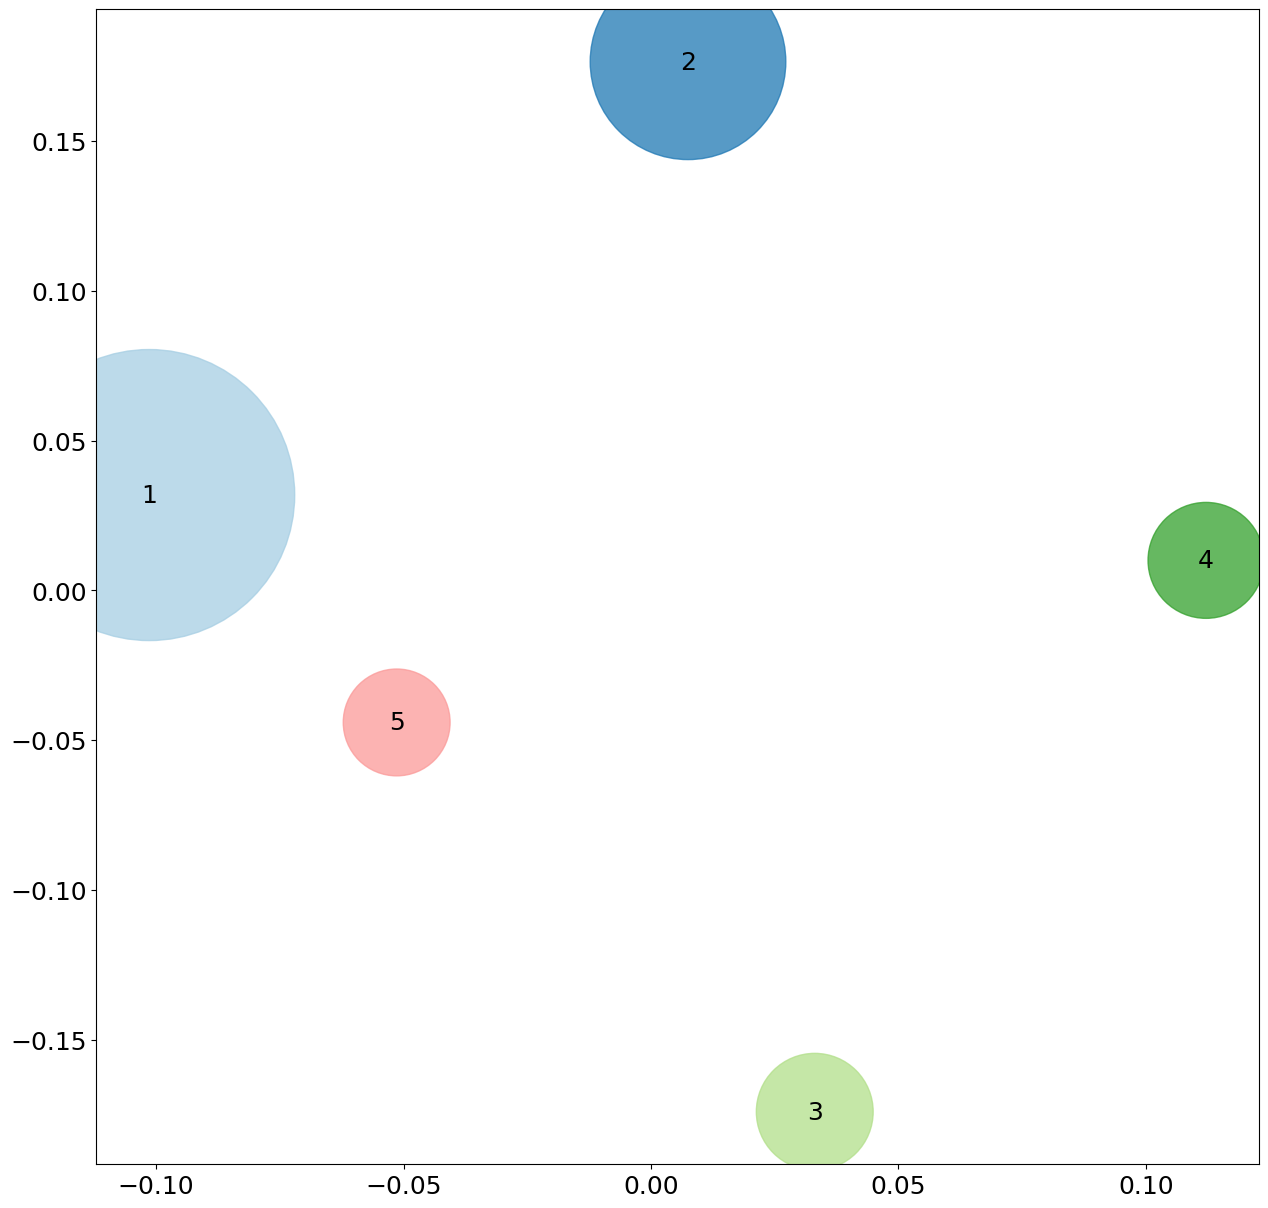

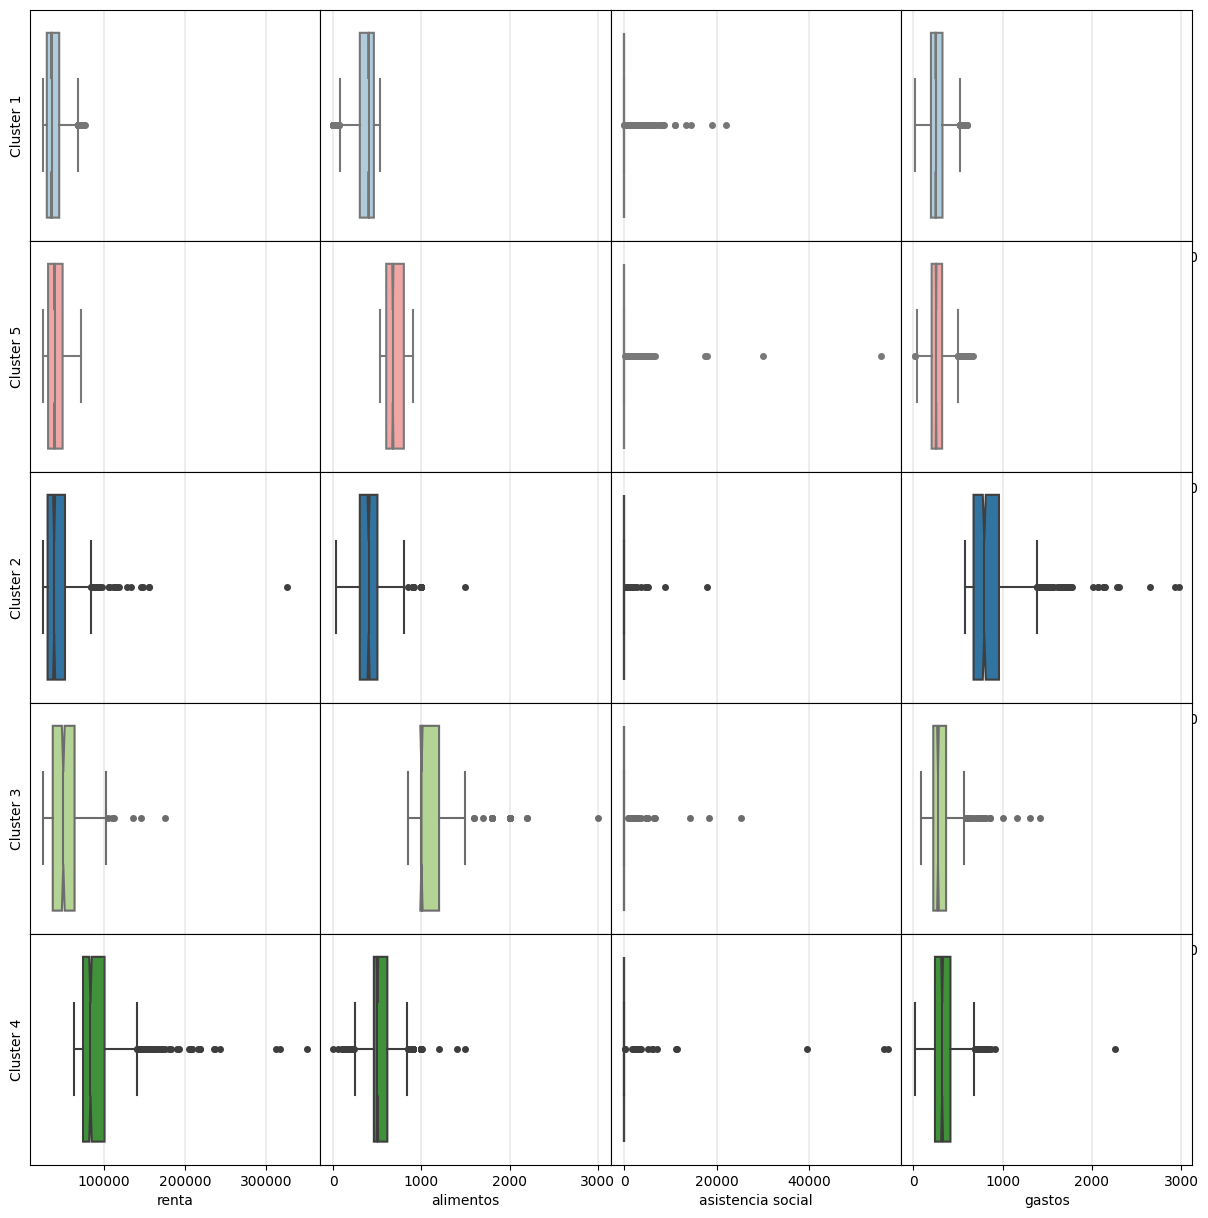

In [ ]:
# (datos['HY020']<15000) | (datos['HY020'] > 25000)
datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)


carpeta = "./caso2B/"
lista_tabla = []


subset = datos.loc[((datos['HY020'] > 25000))]
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HC010":"alimentos", "HY060N":"asistencia social", "HH070": "gastos"})

usadas = ['renta', 'alimentos', 'asistencia social', 'gastos']



n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)

X = eliminar_outliers(X) 

print("\n\n\n")
for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)

# normalizamos
X_normal = X.apply(norm_to_zero_one)

for col in datos:
   missing_count = sum(pd.isnull(datos[col]))
   if missing_count > 0:
      print(col,missing_count)

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        res, cluster_predict, tiempo = kmeans(X_normal)
    elif algoritmos[i] == 'birch':
        res, cluster_predict, tiempo = birch(15, 0.1, X_normal)
    elif algoritmos[i] == 'spectral':
        res, cluster_predict, tiempo = spectralcluster(5, X_normal)
    elif algoritmos[i] == 'dbscan':
        res, cluster_predict, tiempo = alg_dbscan(0.126, 20, X_normal)
    elif algoritmos[i] == 'meanshift':
        bw = estimate_bandwidth(X_normal)
        res, cluster_predict, tiempo = meanshift(bw, X_normal)
    
    try:
        print("\n\nMedidas\n\n")
        ch = metrica_CH(X_normal, cluster_predict)

        sc = metrica_SC(X_normal, cluster_predict)
    except:
        print("\n\nDe medidas nada\n\n")
    
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tam_clusters, size = tamanio_clusters(clusters)

    centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

    s = algoritmos[i]  + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"
    
    lista_tabla.append(s)

    carpeta2 = carpeta + algoritmos[i] + "/"
    
    if algoritmos[i] == 'kmeans':
      
      '''try:
          parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
      except:
          print("de parallel nada")'''
      
      
      try:
          heatmap(centers, centers_desnormal, size, carpeta2)
      except:
          print("dep1")
      try:
          graf_MDS(centers, size, carpeta2)
      except:
          print("dep2")
      try:
          boxplot(size, centers, carpeta2)
      except:
          print("dep3")
      #scatter_matrix(X, clusters, size, carpeta2)

    #if algoritmos[i] == 'kmeans':
      #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

In [ ]:
# PARAMETROS DBSCAN

datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

carpeta = "./caso2B/"
lista_tabla = []


subset = datos.loc[((datos['HY020'] > 25000))]
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HC010":"alimentos", "HY060N":"asistencia social", "HH070": "gastos"})

usadas = ['renta', 'alimentos', 'asistencia social', 'gastos']




n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X) 

# normalizamos
X_normal = X.apply(norm_to_zero_one)


param_dbscan_eps = [0.126, 0.130, 0.150, 0.170, 0.2]
param_dbscan_min_samples = [15, 20, 25, 30, 35]
for i in range(0, len(param_birch_branching)):
  for j in range(0, len(param_birch_threshold)):
        res, cluster_predict, tiempo = alg_dbscan(param_dbscan_eps[i], param_dbscan_min_samples[j], X_normal)
    
        try:
            print("\n\nMedidas\n\n")
            ch = metrica_CH(X_normal, cluster_predict)

            sc = metrica_SC(X_normal, cluster_predict)
        except:
            print("\n\nDe medidas nada\n\n")
        
        # se convierte la asignación de clusters a DataFrame
        clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

        tam_clusters, size = tamanio_clusters(clusters)

        #centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

        s = "dbscan"  + " & "
        s += "{:.3f}".format(param_dbscan_eps[i]) + " & "
        s += "{:.3f}".format(param_dbscan_min_samples[j]) + " & "
        s += "{:.3f}".format(tiempo) + " & "
        s += "{:.3f}".format(ch) + " & "
        s += "{:.5f}".format(sc) + " & "
        s += "{:.0f}".format(len(size)) + " \\\\"
        
        lista_tabla.append(s)

#carpeta2 = carpeta + algoritmos[i] + "/"
    
      #if algoritmos[i] == 'spectral':
          
        '''try:
            parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
        except:
            print("de parallel nada")'''
        
        
        '''try:
            heatmap(centers, centers_desnormal, size, carpeta2)
        except:
            print("dep1")
        try:
            graf_MDS(centers, size, carpeta2)
        except:
            print("dep2")
        try:
            boxplot(size, centers, carpeta2)
        except:
            print("dep3")
        #scatter_matrix(X, clusters, size, carpeta2)'''

      #if algoritmos[i] == 'kmeans':
        #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

          renta  alimentos  asistencia social  gastos
4      39660.00      400.0               0.00  381.53
5      65000.00      400.0               0.00  249.06
6      30030.00      300.0               0.00  420.68
7      49077.30      400.0               0.00  326.22
8      30795.30      300.0               0.00  211.52
...         ...        ...                ...     ...
15031  29746.40      300.0               0.00  242.69
15034  26860.60      400.0               0.00  192.98
15035  27481.50      300.0               0.00  155.91
15038  39969.70      600.0            1200.00  179.37
15039  66003.88      300.0            2503.98  304.87

[8372 rows x 4 columns]
----- Ejecutando DBSCAN: 2.37 segundos, 

Medidas


Calinski-Harabasz Index: 468.250, Silhouette Coefficient: 0.76037
Tamaño de cada cluster:
0:  8327 (99.46%)
-1:    45 ( 0.54%)
----- Ejecutando DBSCAN: 1.64 segundos, 

Medidas


Calinski-Harabasz Index: 473.629, Silhouette Coefficient: 0.75774
Tamaño de cada cluster:
0:  83

In [ ]:
# PARAMETROS KMEANS

datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

carpeta = "./caso2B/"
lista_tabla = []


subset = datos.loc[((datos['HY020'] > 25000))]
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HC010":"alimentos", "HY060N":"asistencia social", "HH070": "gastos"})

usadas = ['renta', 'alimentos', 'asistencia social', 'gastos']


n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X) 

# normalizamos
X_normal = X.apply(norm_to_zero_one)



param_kmeans_nclusters = [3,4,5,6,7,8,9,10]
for i in range(0, len(param_kmeans_nclusters)):
      res, cluster_predict, tiempo = kmeans(X_normal, param_kmeans_nclusters[i])
  
      try:
          print("\n\nMedidas\n\n")
          ch = metrica_CH(X_normal, cluster_predict)

          sc = metrica_SC(X_normal, cluster_predict)
      except:
          print("\n\nDe medidas nada\n\n")
      
      # se convierte la asignación de clusters a DataFrame
      clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

      tam_clusters, size = tamanio_clusters(clusters)

      #centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

      s = "kmeans"  + " & "
      s += "{:.3f}".format(param_kmeans_nclusters[i]) + " & "
      s += "{:.3f}".format(tiempo) + " & "
      s += "{:.3f}".format(ch) + " & "
      s += "{:.5f}".format(sc) + " & "
      s += "{:.0f}".format(len(size)) + " \\\\"
      
      lista_tabla.append(s)

#carpeta2 = carpeta + algoritmos[i] + "/"
  
    #if algoritmos[i] == 'spectral':
        
      '''try:
          parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
      except:
          print("de parallel nada")'''
      
      
      '''try:
          heatmap(centers, centers_desnormal, size, carpeta2)
      except:
          print("dep1")
      try:
          graf_MDS(centers, size, carpeta2)
      except:
          print("dep2")
      try:
          boxplot(size, centers, carpeta2)
      except:
          print("dep3")
      #scatter_matrix(X, clusters, size, carpeta2)'''

    #if algoritmos[i] == 'kmeans':
      #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

          renta  alimentos  asistencia social  gastos
4      39660.00      400.0               0.00  381.53
5      65000.00      400.0               0.00  249.06
6      30030.00      300.0               0.00  420.68
7      49077.30      400.0               0.00  326.22
8      30795.30      300.0               0.00  211.52
...         ...        ...                ...     ...
15031  29746.40      300.0               0.00  242.69
15034  26860.60      400.0               0.00  192.98
15035  27481.50      300.0               0.00  155.91
15038  39969.70      600.0            1200.00  179.37
15039  66003.88      300.0            2503.98  304.87

[8372 rows x 4 columns]
----- Ejecutando k-Means: 0.39 segundos, 

Medidas


Calinski-Harabasz Index: 3085.841, Silhouette Coefficient: 0.39834
Tamaño de cada cluster:
2:  5670 (67.73%)
1:  1919 (22.92%)
0:   783 ( 9.35%)
----- Ejecutando k-Means: 0.24 segundos, 

Medidas


Calinski-Harabasz Index: 3065.400, Silhouette Coefficient: 0.40218
Tamaño de

In [ ]:
datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

carpeta = "./caso3/"
lista_tabla = []


subset = datos.loc[((datos['HH021'] > 1))]
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HH031":"año contrato", "HY060N":"asistencia social", "HX040":"num miembros", "HH070": "gastos"})

usadas = ['renta', 'año contrato', 'asistencia social', 'num miembros', 'gastos']



n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X) 

# normalizamos
X_normal = X.apply(norm_to_zero_one)

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        res, cluster_predict, tiempo = kmeans(X_normal)
    elif algoritmos[i] == 'birch':
        res, cluster_predict, tiempo = birch(15, 0.1, X_normal)
    elif algoritmos[i] == 'spectral':
        res, cluster_predict, tiempo = spectralcluster(5, X_normal)
    elif algoritmos[i] == 'dbscan':
        res, cluster_predict, tiempo = alg_dbscan(0.126, 20, X_normal)
    elif algoritmos[i] == 'meanshift':
        bw = estimate_bandwidth(X_normal)
        res, cluster_predict, tiempo = meanshift(bw, X_normal)

    
    try:
        print("\n\nMedidas\n\n")
        ch = metrica_CH(X_normal, cluster_predict)

        sc = metrica_SC(X_normal, cluster_predict)
    except:
        print("\n\nDe medidas nada\n\n")
    
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tam_clusters, size = tamanio_clusters(clusters)

    centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

    s = algoritmos[i]  + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"
    
    lista_tabla.append(s)

    carpeta2 = carpeta + algoritmos[i] + "/"
    

    if algoritmos[i] == 'kmeans':
       
      try:
          parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
      except:
          print("de parallel nada")
      
      
      '''try:
          heatmap(centers, centers_desnormal, size, carpeta2)
      except:
          print("dep1")
      try:
          graf_MDS(centers, size, carpeta2)
      except:
          print("dep2")
      try:
          boxplot(size, centers, carpeta2)
      except:
          print("dep3")'''
      #scatter_matrix(X, clusters, size, carpeta2)

    #if algoritmos[i] == 'kmeans':
      #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

          renta  año contrato  asistencia social  num miembros  gastos
2      24500.00        2003.0               0.00             1  382.55
3      16033.10        2004.0               0.00             3  265.47
4      39660.00        2010.0               0.00             4  381.53
6      30030.00        2010.0               0.00             4  420.68
7      49077.30        2011.0               0.00             5  326.22
...         ...           ...                ...           ...     ...
15034  26860.60        2003.0               0.00             4  192.98
15036  19934.98        2013.0               0.00             2  591.77
15039  66003.88        2013.0            2503.98             5  304.87
15041   5564.10        2010.0               0.00             1   67.70
15042  12728.00        2009.0               0.00             2  300.75

[7295 rows x 5 columns]
----- Ejecutando k-Means: 0.28 segundos, 

Medidas


Calinski-Harabasz Index: 3093.890, Silhouette Coefficient: 0.30029
Tam

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names



: 0.26 segundos, 

Medidas


Calinski-Harabasz Index: 1564.817, Silhouette Coefficient: 0.29725
Tamaño de cada cluster:
1:  3582 (49.10%)
3:  3263 (44.73%)
4:   268 ( 3.67%)
0:   147 ( 2.02%)
2:    35 ( 0.48%)
a
b
----- Ejecutando spectralc luster: 13.97 segundos, 

Medidas


Calinski-Harabasz Index: 2264.359, Silhouette Coefficient: 0.26693
Tamaño de cada cluster:
2:  2490 (34.13%)
0:  2238 (30.68%)
4:  1191 (16.33%)
3:  1111 (15.23%)
1:   265 ( 3.63%)
a
b
----- Ejecutando DBSCAN: 0.81 segundos, 

Medidas


Calinski-Harabasz Index: 224.569, Silhouette Coefficient: 0.57976
Tamaño de cada cluster:
0:  7207 (98.79%)
-1:    88 ( 1.21%)
a
b
----- Ejecutando meanshift : 53.03 segundos, 

Medidas


Calinski-Harabasz Index: 142.825, Silhouette Coefficient: 0.32008
Tamaño de cada cluster:
0:  7006 (96.04%)
3:   138 ( 1.89%)
2:    95 ( 1.30%)
11:    19 ( 0.26%)
1:     9 ( 0.12%)
8:     7 ( 0.10%)
10:     5 ( 0.07%)
9:     5 ( 0.07%)
7:     4 ( 0.05%)
5:     3 ( 0.04%)
4:     2 ( 0.03%)
6:     1

<Figure size 640x480 with 0 Axes>

In [ ]:
# PARAMETROS MEANSHIFT

datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

carpeta = "./caso3/"
lista_tabla = []

subset = datos.loc[((datos['HH021'] > 1))]
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HH031":"año contrato", "HY060N":"asistencia social", "HX040":"num miembros", "HH070": "gastos"})

usadas = ['renta', 'año contrato', 'asistencia social', 'num miembros', 'gastos']



n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X) 

# normalizamos
X_normal = X.apply(norm_to_zero_one)


param_meanshift_bw = [-1, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in range(0, len(param_meanshift_bw)):
    if param_meanshift_bw[i] == -1:
        param_meanshift_bw[i] = estimate_bandwidth(X_normal)


    res, cluster_predict, tiempo = meanshift(param_meanshift_bw[i], X_normal)
    
    try:
        print("\n\nMedidas\n\n")
        ch = metrica_CH(X_normal, cluster_predict)

        sc = metrica_SC(X_normal, cluster_predict)
    except:
        print("\n\nDe medidas nada\n\n")
    
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tam_clusters, size = tamanio_clusters(clusters)

    #centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

    s = "meanshift"  + " & "
    s += "{:.3f}".format(param_meanshift_bw[i]) + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"
    
    lista_tabla.append(s)

    #carpeta2 = carpeta + algoritmos[i] + "/"
    

    '''if algoritmos[i] == 'kmeans':
       
      try:
          parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
      except:
          print("de parallel nada")'''
      
      
    '''try:
        heatmap(centers, centers_desnormal, size, carpeta2)
    except:
        print("dep1")
    try:
        graf_MDS(centers, size, carpeta2)
    except:
        print("dep2")
    try:
        boxplot(size, centers, carpeta2)
    except:
        print("dep3")'''
    #scatter_matrix(X, clusters, size, carpeta2)

  #if algoritmos[i] == 'kmeans':
    #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

          renta  año contrato  asistencia social  num miembros  gastos
2      24500.00        2003.0               0.00             1  382.55
3      16033.10        2004.0               0.00             3  265.47
4      39660.00        2010.0               0.00             4  381.53
6      30030.00        2010.0               0.00             4  420.68
7      49077.30        2011.0               0.00             5  326.22
...         ...           ...                ...           ...     ...
15034  26860.60        2003.0               0.00             4  192.98
15036  19934.98        2013.0               0.00             2  591.77
15039  66003.88        2013.0            2503.98             5  304.87
15041   5564.10        2010.0               0.00             1   67.70
15042  12728.00        2009.0               0.00             2  300.75

[7295 rows x 5 columns]
----- Ejecutando meanshift : 60.35 segundos, 

Medidas


Calinski-Harabasz Index: 142.825, Silhouette Coefficient: 0.32008


In [ ]:
# PARAMETROS SPECTRAL CLUSTER

datos = pd.read_csv('/content/drive/MyDrive/datos_hogar_2020.csv')

imputar_valores_perdidos(datos)

carpeta = "./caso3/"
lista_tabla = []


subset = datos.loc[((datos['HH021'] > 1))]
# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HH031":"año contrato", "HY060N":"asistencia social", "HX040":"num miembros", "HH070": "gastos"})

usadas = ['renta', 'año contrato', 'asistencia social', 'num miembros', 'gastos']



n_var = len(usadas)
X = subset[usadas]
n_var = len(usadas)
X = subset[usadas]
print(X)


algoritmos = ['kmeans', 'birch', 'spectral', 'dbscan', 'meanshift']

X = eliminar_outliers(X) 

# normalizamos
X_normal = X.apply(norm_to_zero_one)


param_spectral_nclusters = [3,4,5,6,7,8,9,10]
for i in range(0, len(param_spectral_nclusters)):
    res, cluster_predict, tiempo = spectralcluster(param_spectral_nclusters[i], X_normal)
    
    try:
        print("\n\nMedidas\n\n")
        ch = metrica_CH(X_normal, cluster_predict)

        sc = metrica_SC(X_normal, cluster_predict)
    except:
        print("\n\nDe medidas nada\n\n")
    
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tam_clusters, size = tamanio_clusters(clusters)

    #centers, centers_desnormal = calcular_centros(algoritmos[i], X, res, cluster_predict)

    s = "spectral"  + " & "
    s += "{:.3f}".format(param_spectral_nclusters[i]) + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"
    
    lista_tabla.append(s)

    #carpeta2 = carpeta + algoritmos[i] + "/"
    

    '''if algoritmos[i] == 'kmeans':
       
      try:
          parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)
      except:
          print("de parallel nada")'''
      
      
    '''try:
        heatmap(centers, centers_desnormal, size, carpeta2)
    except:
        print("dep1")
    try:
        graf_MDS(centers, size, carpeta2)
    except:
        print("dep2")
    try:
        boxplot(size, centers, carpeta2)
    except:
        print("dep3")'''
    #scatter_matrix(X, clusters, size, carpeta2)

  #if algoritmos[i] == 'kmeans':
    #parallel_coord(clusters, cluster_predict, X, X_normal, size, carpeta2)

tabla_alg(lista_tabla)

          renta  año contrato  asistencia social  num miembros  gastos
2      24500.00        2003.0               0.00             1  382.55
3      16033.10        2004.0               0.00             3  265.47
4      39660.00        2010.0               0.00             4  381.53
6      30030.00        2010.0               0.00             4  420.68
7      49077.30        2011.0               0.00             5  326.22
...         ...           ...                ...           ...     ...
15034  26860.60        2003.0               0.00             4  192.98
15036  19934.98        2013.0               0.00             2  591.77
15039  66003.88        2013.0            2503.98             5  304.87
15041   5564.10        2010.0               0.00             1   67.70
15042  12728.00        2009.0               0.00             2  300.75

[7295 rows x 5 columns]
----- Ejecutando spectralc luster: 16.17 segundos, 

Medidas


Calinski-Harabasz Index: 3711.819, Silhouette Coefficient: 0

In [16]:
!zip -r /content/caso3.zip /content/caso3
!zip -r /content/caso2B.zip /content/caso2B
!zip -r /content/caso2A.zip /content/caso2A
!zip -r /content/caso1.zip /content/caso1

  adding: content/caso1/ (stored 0%)
  adding: content/caso1/.ipynb_checkpoints/ (stored 0%)
  adding: content/caso1/spectral/ (stored 0%)
  adding: content/caso1/spectral/boxplot.png (deflated 19%)
  adding: content/caso1/spectral/scatter.png (deflated 1%)
  adding: content/caso1/spectral/parallel.html (deflated 70%)
  adding: content/caso1/spectral/mds.png (deflated 27%)
  adding: content/caso1/spectral/heatmap.png (deflated 12%)
  adding: content/caso1/meanshift/ (stored 0%)
  adding: content/caso1/meanshift/scatter.png (deflated 1%)
  adding: content/caso1/kmeans/ (stored 0%)
  adding: content/caso1/kmeans/scatter.png (deflated 1%)
  adding: content/caso1/dbscan/ (stored 0%)
  adding: content/caso1/dbscan/scatter.png (deflated 1%)
  adding: content/caso1/birch/ (stored 0%)
  adding: content/caso1/birch/scatter.png (deflated 1%)
